# Recommender Systems: Progetto Portfolio

In questo progetto portfolio si implementerà un sistema di raccomandazioni basato sul Collaborative-Filtering (CF) a partire dal dataset MovieLens, comune quando si testano e implementano recommender engines. Si proverà un CF Memory-Based calcolando il coseno di similitudine (**cosine similarity**) e un CF Model-Based con la Decomposizione ai valori singolari (**Singular Value Decomposition** o **SVD**).

## Importare librerie

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

## Ottenere i dati

Una descrizione sommaria del dataset si ha a questo [link](http://files.grouplens.org/datasets/movielens/ml-100k-README.txt).

In [3]:
column_names = ['user_id','item_id','rating','timestamp']
movies_df = pd.read_csv('u.data',sep='\t',names=column_names) # il dataset è separato da tabulazioni

In [4]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100003 entries, 0 to 100002
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100003 non-null  int64
 1   item_id    100003 non-null  int64
 2   rating     100003 non-null  int64
 3   timestamp  100003 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [5]:
movies_df.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


Dato che non si hanno i nomi dei film, ma i loro relativi id, utilizziamo il file csv 'Movie_ID_Titles'.

In [6]:
titles = pd.read_csv('Movie_Id_Titles')
titles.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [7]:
movies_df = pd.merge(movies_df,titles,on='item_id')
movies_df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


Si indaga il numero di utenti e film unici nel dataset.

In [9]:
n_users= movies_df['user_id'].nunique()
n_items = movies_df['item_id'].nunique()

print('Numero utenti unici: ',n_users)
print('Numero film unici: ',n_items)

Numero utenti unici:  944
Numero film unici:  1682


## EDA

Si visualizza brevemente il contenuto del dataset e i film con rating migliore.

In [11]:
# Primi 20 film ordinati per miglior media rating 
movies_df.groupby('title')['rating'].mean().sort_values(ascending=False).head(20)

title
They Made Me a Criminal (1939)                            5.000000
Marlene Dietrich: Shadow and Light (1996)                 5.000000
Saint of Fort Washington, The (1993)                      5.000000
Someone Else's America (1995)                             5.000000
Star Kid (1997)                                           5.000000
Great Day in Harlem, A (1994)                             5.000000
Aiqing wansui (1994)                                      5.000000
Santa with Muscles (1996)                                 5.000000
Prefontaine (1997)                                        5.000000
Entertaining Angels: The Dorothy Day Story (1996)         5.000000
Pather Panchali (1955)                                    4.625000
Some Mother's Son (1996)                                  4.500000
Maya Lin: A Strong Clear Vision (1994)                    4.500000
Anna (1996)                                               4.500000
Everest (1998)                                          

**Alcuni dei primi film per rating non sono molto conosciuti, questo perché non si sta considerando il numero assoluto di recensioni relative ai film. Probabilmente molti film con media rating 5.0 ma sconosciuti ai più hanno una recensione.**

In [12]:
# Primi 20 film per numero di recensioni lasciate
movies_df.groupby('title')['rating'].count().sort_values(ascending=False).head(20)

title
Star Wars (1977)                    584
Contact (1997)                      509
Fargo (1996)                        508
Return of the Jedi (1983)           507
Liar Liar (1997)                    485
English Patient, The (1996)         481
Scream (1996)                       478
Toy Story (1995)                    452
Air Force One (1997)                431
Independence Day (ID4) (1996)       429
Raiders of the Lost Ark (1981)      420
Godfather, The (1972)               413
Pulp Fiction (1994)                 394
Twelve Monkeys (1995)               392
Silence of the Lambs, The (1991)    390
Jerry Maguire (1996)                384
Chasing Amy (1997)                  379
Rock, The (1996)                    378
Empire Strikes Back, The (1980)     368
Star Trek: First Contact (1996)     365
Name: rating, dtype: int64

Si cerca di rimediare a questo problema creando un dataframe con media rating e numero di recensioni.

In [21]:
ratings = pd.DataFrame({'mean_rating': movies_df.groupby('title')['rating'].mean(),
                        'num_of_ratings': movies_df.groupby('title')['rating'].count()})
ratings.head(10)

,mean_rating,num_of_ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41
2 Days in the Valley (1996),3.225806,93
"20,000 Leagues Under the Sea (1954)",3.500000,72
2001: A Space Odyssey (1968),3.969112,259
3 Ninjas: High Noon At Mega Mountain (1998),1.000000,5


Si fa un po' di EDA su questo dataframe.

<AxesSubplot:>

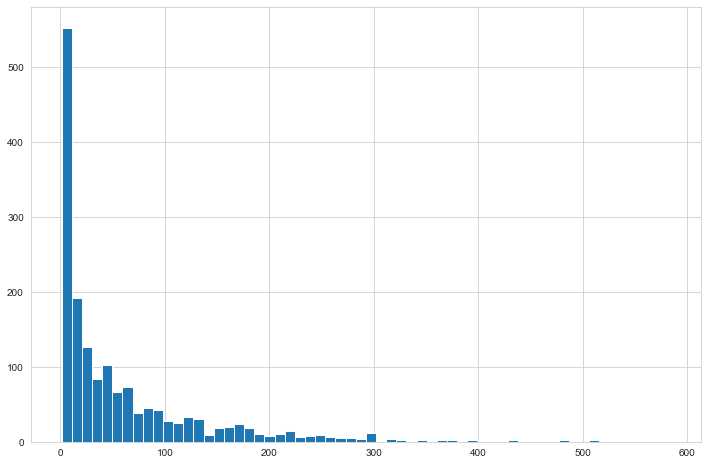

In [28]:
# Distribuzione numero di recensioni per film
plt.figure(figsize=(12,8))
ratings['num_of_ratings'].hist(bins=60)

**La distribuzione di numero di rating per film è assolutamente centrata a piccoli valori tendenente all'1, che è un andamento comprensibile. Questo però potrebbe essere problematico per un recommender engine, soprattutto se molto semplice, infatti il modello verrebbe molto deviato da voti a film fatti da pochissime persone.**

<AxesSubplot:xlabel='mean_rating', ylabel='Count'>

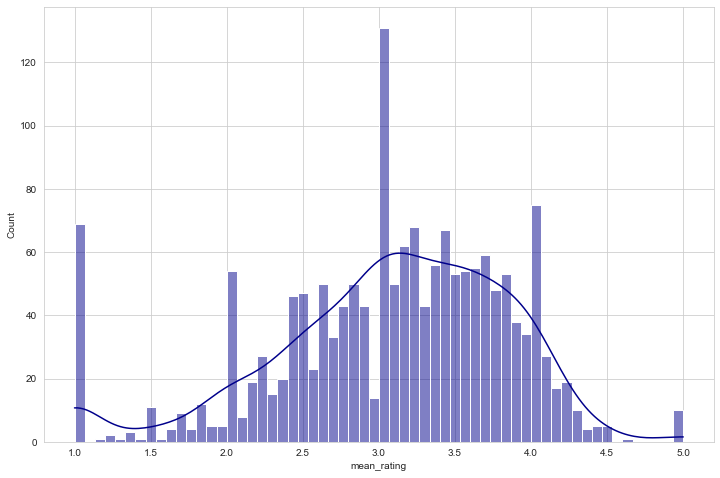

In [60]:
# Distribuzione media rating per film 
plt.figure(figsize=(12,8))
sns.histplot(data=ratings,x=ratings['mean_rating'],kde=True,bins=60,color='DarkBlue')

**La distribuzione delle medie rating presentano dei picchi per i valori interi della scala di voti, questo ha senso perché nel dataset ci saranno molti film con poche recensioni e magari con lo stesso voto.**

Si confrontano le due distribuzioni con un jointplot.

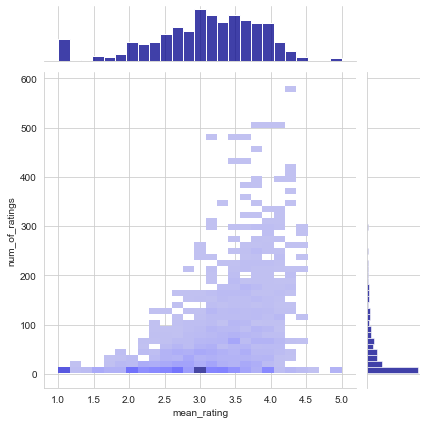

In [61]:
sns.jointplot(data=ratings,x='mean_rating',y='num_of_ratings',kind='hist',color='DarkBlue')

**Si notano i picchi di media rating interi che corrispondono a poche recensioni come preannunciato. Si può vedere come per maggior numero di recensioni la media rating tenda a valori intermedi tra l'1 e il 5, in particolare tra 2.5 e 4.5 per numero recensioni maggiori di 100.**

## Training & Test Data

Invece che splittare il dataset in X_train, y_train, X_test, y_test come di solito si fa, si divide il dataset in due segmenti.

In [62]:
from sklearn.model_selection import train_test_split

In [63]:
train_data, test_data = train_test_split(movies_df,test_size=0.3,random_state=42)

## Memory-Based CF: cosine similarity

Come primo approccio si utilizzerà il coseno di similitudine per generare un recommender engine. Si farà un filtro user-item, che suggerisce items piaciuti agli users simili ad un particolare utente, e uno item-item, che invece consiglia items piaciuti ad users che hanno un particolare item piaciuto in comune.

Si crea una matrice user-item per il training e una per il testing.

In [83]:
train_data_mat = np.zeros((n_users,n_items))

In [84]:
# Si riempie la precedente matrice con i rating di un user a un particolare item
for line in train_data.itertuples():
    train_data_mat[line[1]-1,line[2]-1] = line[3]

In [85]:
train_data_mat

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

**È una cosiddetta matrice sparsa, infatti è altamente improbabile che molti utenti abbiano visto e recensito la maggior parte di film del dataset.**

In [86]:
test_data_mat = np.zeros((n_users,n_items))
for line in test_data.itertuples():
    test_data_mat[line[1]-1,line[2]-1] = line[3]

Si calcola il coseno di similitudine con una funzione di scikit-learn.

In [87]:
from sklearn.metrics.pairwise import pairwise_distances

In [89]:
user_similarity = pairwise_distances(train_data_mat, metric='cosine')
item_similarity = pairwise_distances(train_data_mat.T, metric='cosine')

Ora che si hanno i coseni di similitudine, si devono fare delle previsioni.

### User-based CF

Si applica la seguente formula per le previsioni sul filtro user-item:

<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?\hat{x}_{k,m}&space;=&space;\bar{x}_{k}&space;&plus;&space;\frac{\sum\limits_{u_a}&space;sim_u(u_k,&space;u_a)&space;(x_{a,m}&space;-&space;\bar{x_{u_a}})}{\sum\limits_{u_a}|sim_u(u_k,&space;u_a)|}"/>

Per prevedere il rating di un utente *k* all'item *m* si somma alla media delle recensioni dell'utente *k* la somma, su tutti gli altri utenti *u_a*, la differenza fra il voto dato dall'utente *a* all'item *m* e la sua media voto pesata dal coseno di similitudine fra utente *k* e *a*, normalizzando il tutto per il valore assoluto dello stesso coseno di similitudine così da mantenere il rating dell'utente *k* all'item *m* tra 1 e 5.

In [99]:
mean_user_rating = train_data_mat.mean(axis=1)
diff_rating = (train_data_mat - mean_user_rating[:,np.newaxis])
user_pred = mean_user_rating[:,np.newaxis] + user_similarity.dot(diff_rating)/np.array([np.abs(user_similarity).sum(axis=1)]).T

### Item-based CF

Si applica la seguente formula per le previsioni sul filtro item-item:

<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?\hat{x}_{k,m}&space;=&space;\frac{\sum\limits_{i_b}&space;sim_i(i_m,&space;i_b)&space;(x_{k,b})&space;}{\sum\limits_{i_b}|sim_i(i_m,&space;i_b)|}"/>

La formula è totalmente analoga a quella precedente, con l'unica differenza data dal fatto che non servono più le correzioni dei voti medi degli utenti perché impliciti nei coseni di similitudine basati sugli item.

In [116]:
item_pred = train_data_mat.dot(item_similarity)/np.array([np.abs(item_similarity).sum(axis=1)])     

## Performance del Modello

Si valuta il potere predittivo del modello Memory-Based CF calcolando il Root Mean Squared Error (RMSE).

In [117]:
from sklearn.metrics import mean_squared_error

In [129]:
user_prediction = user_pred[test_data_mat.nonzero()]
user_prediction

array([0.44978625, 0.30219553, 1.23250423, ..., 0.21803109, 0.30231016,
       0.26056874])

In [130]:
item_prediction = item_pred[test_data_mat.nonzero()]
item_prediction

array([0.36944399, 0.39138662, 0.33644471, ..., 0.23861006, 0.24411384,
       0.233369  ])

In [158]:
test_data_mat_nonzero = test_data_mat[test_data_mat.nonzero()]
test_data_mat_nonzero

array([3., 5., 4., ..., 1., 2., 4.])

In [159]:
print('RMSE dell\'User-based CF:',np.sqrt(mean_squared_error(user_prediction,test_data_mat_nonzero)))
print('RMSE dell\'Item-based CF:',np.sqrt(mean_squared_error(item_prediction,test_data_mat_nonzero)))

RMSE dell'User-based CF: 3.161679578914151
RMSE dell'Item-based CF: 3.4670906022955386


**Gli algoritmi Memory-based CF sono abbastanza facili da implementare e producono buone previsioni, il problema è che non sono scalabili a problemi del mondo reale e non risolvono il problema del cold-start, ovvero quando un nuovo user o item entrano nel sistema. Invece i metodi Model-based CF sono scalabili e riescono a trattare matrici sparse che i Memory-based non sostengono dopo un certo livello, purtroppo anch'essi soffrono del cold-start che viene risolto solo da algoritmi ibridi Collaborative-Filtering e Content-Based.** 

## Model-Based CF: SVD

Il Model-based CF si basa sulla decomposizione matriciale (MF), utilizzata spesso come metodo di unsupervised learning per la riduzione dimensionale e la decomposizione in variabili latenti. Un metodo di MF molto noto, per via soprattutto del *Netflix Prize*, è la Decomposizione ai valori singolari o, dall'inglese Singular Value Decomposition, **SVD**. 

L'equazione generale della SVD è la seguente:
<img src="https://latex.codecogs.com/gif.latex?X=USV^T" title="X=USV^T" />


Dove la matrice data *X*, da approssimare con la SVD, è *(m x n)*:
* *U* è una matrice ortogonale *(m x r)*
* *S* è una matrice diagonale *(r x r)* con numeri reali non negativi
* *V^T* è una matrice ortogonale *(r x n)* 

Gli elementi sulla diagonale di *S* sono noti come **valori singolari** di *X*, che rappresentano le variabili nascoste per ordine crescente di importanza.

La matrice *U* rappresenta i vettori feature relativi agli user nello spazio delle feature nascoste, mentre la matrice *V* rappresenta i vettori feature relativi agli item nello spazio delle feature nascoste.

Si valuta il livello di sparsity del dataset MovieLens.

In [173]:
sparsity = round(1.0-len(movies_df)/float(n_users*n_items),6)
print('Il livello di sparsity di MovieLens è:', sparsity*100, '%')

Il livello di sparsity di MovieLens è: 93.7018 %


## Performance del Modello

Si indaga se l'algortimo Model-Based CF con SVD dia risultati migliori del Memory-Based confrontando gli RMSE.

In [144]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

Si ottimizza la scelta del parametro *k* in svds().

In [257]:
rmse = []
for i in range(1,100):
    u, s, vt = svds(train_data_mat,k=i)
    s_diag_matrix = np.diag(s)
    X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
    X_predictions = X_pred[test_data_mat.nonzero()]
    rmse.append(np.sqrt(mean_squared_error(X_predictions,test_data_mat_nonzero)))

Text(0, 0.5, 'RMSE')

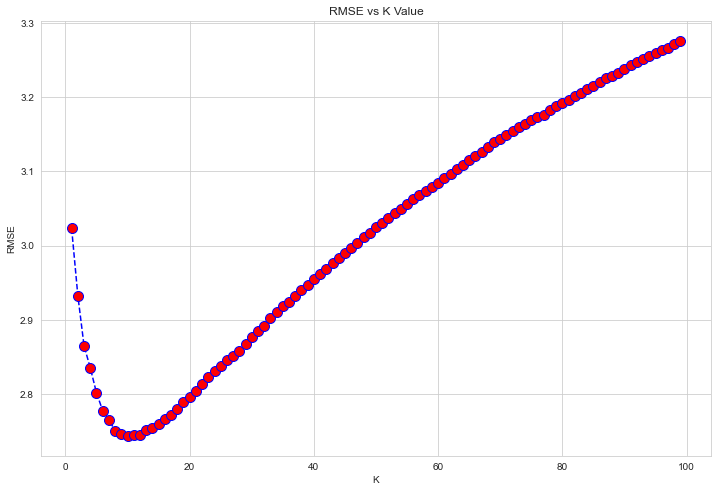

In [258]:
plt.figure(figsize=(12,8))
plt.plot(range(1,100),rmse,color='blue',ls='--',marker='o',
         markerfacecolor='red',markersize=10)
plt.title('RMSE vs K Value')
plt.xlabel('K')
plt.ylabel('RMSE')

**È evidente un bel minimo per k=10, oltre si tende all'overfitting.**

In [279]:
u, s, vt = svds(train_data_mat,k=10)
s_diag_matrix = np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
X_predictions = X_pred[test_data_mat.nonzero()]
print('RMSE del Model-Based CF con SVD:',np.sqrt(mean_squared_error(X_predictions,test_data_mat_nonzero)))

RMSE del Model-Based CF con SVD: 2.7435919378781684


**Il recommender engine Model-Based CF con SVD pare performare meglio di quelli Memory-Based CF in questo caso.**

E qui si conclude il progetto portfolio sui Recommender Systems in cui si sono implementati algoritmi basati sul coseno di similitudine e sul SVD.